# Population

In [3]:
import rasterio as rio
import rasterio.mask 
import pandas as pd 
import numpy as np
import geopandas as gpd 
import os 

from rasterio.plot import show, show_hist 
from rasterstats import zonal_stats 

In [4]:
import matplotlib.pyplot as plt
from rasterio.plot import show

In [5]:
sofia_shapefile_path = './shapefiles/sofia.geojson'
boundaries = gpd.read_file(sofia_shapefile_path)

Now let's see how the population changes over the period. To achieve this: 
* load rasters 
* clip rasters according to the sofia municipality boundaries  
* extral zonal statistics

In [6]:
files_paths = []

In [7]:
for root, dirs, files in os.walk('./data/population-ghs'):
    for file in files:
        if file.endswith('.tif'):
            raster_path = os.path.join(root, file)
            raster = rio.open(raster_path)
            files_paths.append((raster_path, file.split('.')[0]))

In [17]:
files_paths = sorted(files_paths, key=lambda x: x[1])
files_paths

[('./data/population-ghs/1975.tif', '1975'),
 ('./data/population-ghs/1980.tif', '1980'),
 ('./data/population-ghs/1985.tif', '1985'),
 ('./data/population-ghs/1990.tif', '1990'),
 ('./data/population-ghs/1995.tif', '1995'),
 ('./data/population-ghs/2000.tif', '2000'),
 ('./data/population-ghs/2005.tif', '2005'),
 ('./data/population-ghs/2010.tif', '2010'),
 ('./data/population-ghs/2015.tif', '2015'),
 ('./data/population-ghs/2020.tif', '2020')]

In [18]:
raster = rio.open(files_paths[0][0])

In [19]:
boundaries = boundaries.to_crs(raster.crs.data)


In [20]:
stats = []

In [21]:
def get_zonal_stats(raster, boundaries):
    year = raster.name.split('.')[1].split('/')[-1]
    #print(f'Processing {year}')
    res = zonal_stats(boundaries, raster.read(1), stats=['sum', 'mean', 'std', 'min', 'max'], affine=raster.transform, nodata=raster.nodata, geojson_out=True)
    stats.append((year, res[0]['properties']['sum'], res[0]['properties']['mean'], res[0]['properties']['std'], res[0]['properties']['min'], res[0]['properties']['max']))

In [22]:
for path, name in files_paths:
    raster = rio.open(path)
    get_zonal_stats(raster, boundaries)

In [23]:
pop_stats = pd.DataFrame(stats)
pop_stats.columns = ['year', 'sum', 'mean', 'std', 'min', 'max']

In [24]:
pop_stats.index = pop_stats['year']

In [25]:
pop_stats 

,year,sum,mean,std,min,max
year,,,,,,
1975,1975,738287.676975,7.920182,29.374498,0.0,468.920074
1980,1980,811434.300755,8.704882,31.147616,0.0,487.400665
1985,1985,891907.020097,9.568175,33.225681,0.0,507.745209
1990,1990,898749.584956,9.641581,32.670202,0.0,486.019501
1995,1995,881262.202460,9.453980,30.906634,0.0,425.657196
2000,2000,850258.093203,9.121375,29.111011,0.0,383.250916
2005,2005,879760.972260,9.437875,29.109514,0.0,381.223297
2010,2010,914399.251710,9.809467,29.404790,0.0,401.784058
2015,2015,943964.065054,10.126631,29.705601,0.0,416.910095


In [141]:
pop_stats.to_json('./stats/population_stats.json')

In [26]:
def plot_stats(stats, column, title):
    plt.plot(stats['year'], stats[column])
    plt.title(title)
    plt.show()

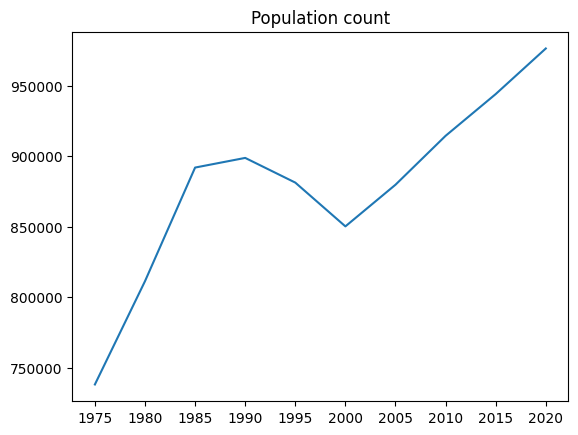

In [27]:
plot_stats(pop_stats, 'sum', 'Population count')

In [28]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

year_dict = {i: files_paths[i][1] for i in range(len(files_paths))}

def plot_raster(year):
    index = list(year_dict.keys())[list(year_dict.values()).index(year)]
    raster = rio.open(files_paths[index][0])
    clipped_raster, transform = rio.mask.mask(raster, boundaries.geometry, crop=True)
    show(clipped_raster[0])
    plt.show()

year_slider = widgets.SelectionSlider(
    options=[(year_dict[i], year_dict[i]) for i in range(len(files_paths))],
    value=year_dict[0],
    description='Year:',
    continuous_update=False
)

interact(plot_raster, year=year_slider)

interactive(children=(SelectionSlider(continuous_update=False, description='Year:', options=(('1975', '1975'),…

<function __main__.plot_raster(year)>